# Lab 11: Dialogue Act Tagging

Dialogue act (DA) tagging is an important step in the process of developing dialog systems. DA tagging is a problem usually solved by supervised machine learning approaches that all require large amounts of hand labeled data. A wide range of techniques have been investigated for DA tagging. In this lab, we explore two approaches to DA classification. We are using the Switchboard Dialog Act Corpus for training.
Corpus can be downloaded from http://compprag.christopherpotts.net/swda.html.


In [1]:
!which python

/homes/nv304/virtpy3/bin/python


The downloaded dataset should be kept in a data folder in the same directory as this file. 

In [2]:
import pandas as pd
import glob
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

import sklearn.metrics
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm

Using TensorFlow backend.
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/homes/nv304/virtpy3/lib/python3.6/site-packages/tensorflow/py

In [3]:
f = glob.glob("swda/sw*/sw*.csv")
frames = []
for i in range(0, len(f)):
    frames.append(pd.read_csv(f[i]))

result = pd.concat(frames, ignore_index=True)
result.to_csv('swda_all_data.csv',index=False)

In [4]:
result = pd.read_csv('swda_all_data.csv')

/homes/nv304/virtpy3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [5]:
print("Number of converations in the dataset:",len(result))


Number of converations in the dataset: 223606


The dataset has many different features, we are only using act_tag and text for this training.


In [6]:
reduced_df = result[['act_tag','text']]


Reduce down the number of tags to 43 - converting the combined tags to their generic classes:

In [7]:
# Imported from "https://github.com/cgpotts/swda"
# Convert the combination tags to the generic 43 tags

import re
def damsl_act_tag(input):
        """
        Seeks to duplicate the tag simplification described at the
        Coders' Manual: http://www.stanford.edu/~jurafsky/ws97/manual.august1.html
        """
        d_tags = []
        tags = re.split(r"\s*[,;]\s*", input)
        for tag in tags:
            if tag in ('qy^d', 'qw^d', 'b^m'): pass
            elif tag == 'nn^e': tag = 'ng'
            elif tag == 'ny^e': tag = 'na'
            else: 
                tag = re.sub(r'(.)\^.*', r'\1', tag)
                tag = re.sub(r'[\(\)@*]', '', tag)            
                if tag in ('qr', 'qy'):                         tag = 'qy'
                elif tag in ('fe', 'ba'):                       tag = 'ba'
                elif tag in ('oo', 'co', 'cc'):                 tag = 'oo_co_cc'
                elif tag in ('fx', 'sv'):                       tag = 'sv'
                elif tag in ('aap', 'am'):                      tag = 'aap_am'
                elif tag in ('arp', 'nd'):                      tag = 'arp_nd'
                elif tag in ('fo', 'o', 'fw', '"', 'by', 'bc'): tag = 'fo_o_fw_"_by_bc'            
            d_tags.append(tag)
        # Dan J says (p.c.) that it makes sense to take the first;
        # there are only a handful of examples with 2 tags here.
        return d_tags[0]

In [8]:
reduced_df["act_tag"] = reduced_df["act_tag"].apply(lambda x: damsl_act_tag(x))

/homes/nv304/virtpy3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
reduced_df['text']

0                                                   Okay. /
1                                                   Okay. /
2                   {D So, } what do you think about it?  /
3                                                Should, -/
4         {F Um, } I like [ the idea of nursing homes [ ...
                                ...                        
223601    {D you know, }  I don't mind spending the extr...
223602                                            Uh-huh. /
223603    -- [ if, + {D you know, } even if ] they pass ...
223604                    I'm not a real big seat belt, - /
223605                                      my, {F uh, } -/
Name: text, Length: 223606, dtype: object

There are 43 tags in this dataset. Some of the tags are Yes-No-Question('qy'), Statement-non-opinion('sd') and Statement-opinion('sv'). Tags information can be found here http://compprag.christopherpotts.net/swda.html#tags. 


To get unique tags:

In [10]:
unique_tags = set()
for tag in reduced_df['act_tag']:
    unique_tags.add(tag)

In [11]:
one_hot_encoding_dic = pd.get_dummies(list(unique_tags))


In [12]:
tags_encoding = []
for i in range(0, len(reduced_df)):
    tags_encoding.append(one_hot_encoding_dic[reduced_df['act_tag'].iloc[i]])

The tags are one hot encoded.

To create sentence embeddings:

In [13]:
sentences = []
for i in range(0, len(reduced_df)):
    sentences.append(reduced_df['text'].iloc[i].split(" "))


In [14]:
wordvectors = {}
index = 1
for s in sentences:
    for w in s:
        if w not in wordvectors:
            wordvectors[w] = index
            index += 1

In [15]:
# Max length of 137
MAX_LENGTH = len(max(sentences, key=len))

In [16]:
sentence_embeddings = []
for s in sentences:
    sentence_emb = []
    for w in s:
        sentence_emb.append(wordvectors[w])
    sentence_embeddings.append(sentence_emb)


Then we split the dataset into test and train.

In [17]:
from sklearn.model_selection import train_test_split
import numpy as np
X_train, X_test, y_train, y_test = train_test_split(sentence_embeddings, np.array(tags_encoding))


And pad the sentences with zero to make all sentences of equal length.


In [18]:
MAX_LENGTH = 137

In [19]:
from keras.preprocessing.sequence import pad_sequences
 
train_sentences_X = pad_sequences(X_train, maxlen=MAX_LENGTH, padding='post')
test_sentences_X = pad_sequences(X_test, maxlen=MAX_LENGTH, padding='post')

Split Train into Train and Validation - about 10% into validation - In order to validate the model as it is training

In [20]:


train_input = train_sentences_X[:140000]
val_input = train_sentences_X[140000:]

train_labels = y_train[:140000]
val_labels = y_train[140000:]


# Model 1 - 

The first approach we'll try is to treat DA tagging as a standard multi-class text classification task, in the way you've done before with sentiment analysis and other tasks. Each utterance will be treated independently as a text to be classified with its DA tag label. This model has an architecture of:

- Embedding  
- BLSTM  
- Fully Connected Layer
- Softmax Activation

 The model architecture is as follows: Embedding Layer (to generate word embeddings) Next layer Bidirectional LSTM. Feed forward layer with number of neurons = number of tags. Softmax activation to get the probabilities.


In [20]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

In [23]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation
##
model = Sequential()
model.add(Embedding(VOCAB_SIZE,EMBED_SIZE,input_length=MAX_LENGTH))
model.add(Bidirectional(LSTM(HIDDEN_SIZE,return_sequences=True,recurrent_dropout=0.7)))
model.add(Bidirectional(LSTM(HIDDEN_SIZE,recurrent_dropout=0.7)))
model.add(Dense(HIDDEN_SIZE))
# model.add(TimeDistributed(Dense(1)))
model.add(Activation('sigmoid'))
##
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 137, 100)          4373100   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 137, 86)           49536     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 86)                44720     
_________________________________________________________________
dense_2 (Dense)              (None, 43)                3741      
_________________________________________________________________
activation_2 (Activation)    (None, 43)                0         
Total params: 4,471,097
Trainable params: 4,471,097
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Train the model - using validation 
history = model.fit(train_input,
                    train_labels,
                    epochs=3,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    verbose=1)

Train on 140000 samples, validate on 27704 samples
Epoch 1/3
140000/140000 [==============================] - 199s 1ms/step - loss: 2.0552 - accuracy: 0.3849 - val_loss: 1.3632 - val_accuracy: 0.6115
Epoch 2/3
140000/140000 [==============================] - 198s 1ms/step - loss: 1.2218 - accuracy: 0.6415 - val_loss: 1.1332 - val_accuracy: 0.6623
Epoch 3/3
140000/140000 [==============================] - 198s 1ms/step - loss: 1.0326 - accuracy: 0.6983 - val_loss: 1.0491 - val_accuracy: 0.6903


In [30]:
score = model.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 67s 1ms/step


In [29]:
print("Overall Accuracy:", score[1]*100)


Overall Accuracy: 68.79181265830994


## Evaluation


The overall accuracy is 67%, an effective accuracy for this task.

In addition to overall accuracy, you need to look at the accuracy of some minority classes. Signal-non-understanding ('br') is a good indicator of "other-repair" or cases in which the other conversational participant attempts to repair the speaker's error. Summarize/reformulate ('bf') has been used in dialogue summarization. Report the accuracy for these classes and some frequent errors you notice the system makes in predicting them. What do you think the reasons are？

## Minority Classes

In [31]:
# Generate predictions for the test data
pred_train= model.predict(train_sentences_X)
scores = model.evaluate(train_sentences_X, y_train, batch_size=100)
print('Accuracy on training data: {}% \n Error on training data: {}'.format(scores[1], 1 - scores[1]))   
 
pred_test= model.predict(test_sentences_X)
scores2 = model.evaluate(test_sentences_X, y_test, batch_size=100)
print('Accuracy on test data: {}% \n Error on test data: {}'.format(scores2[1], 1 - scores2[1]))    

167704/167704 [==============================] - 201s 1ms/step
Accuracy on training data: 0.7213364243507385% 
 Error on training data: 0.2786635756492615
55902/55902 [==============================] - 66s 1ms/step
Accuracy on test data: 0.6879181265830994% 
 Error on test data: 0.31208187341690063


Normalized confusion matrix


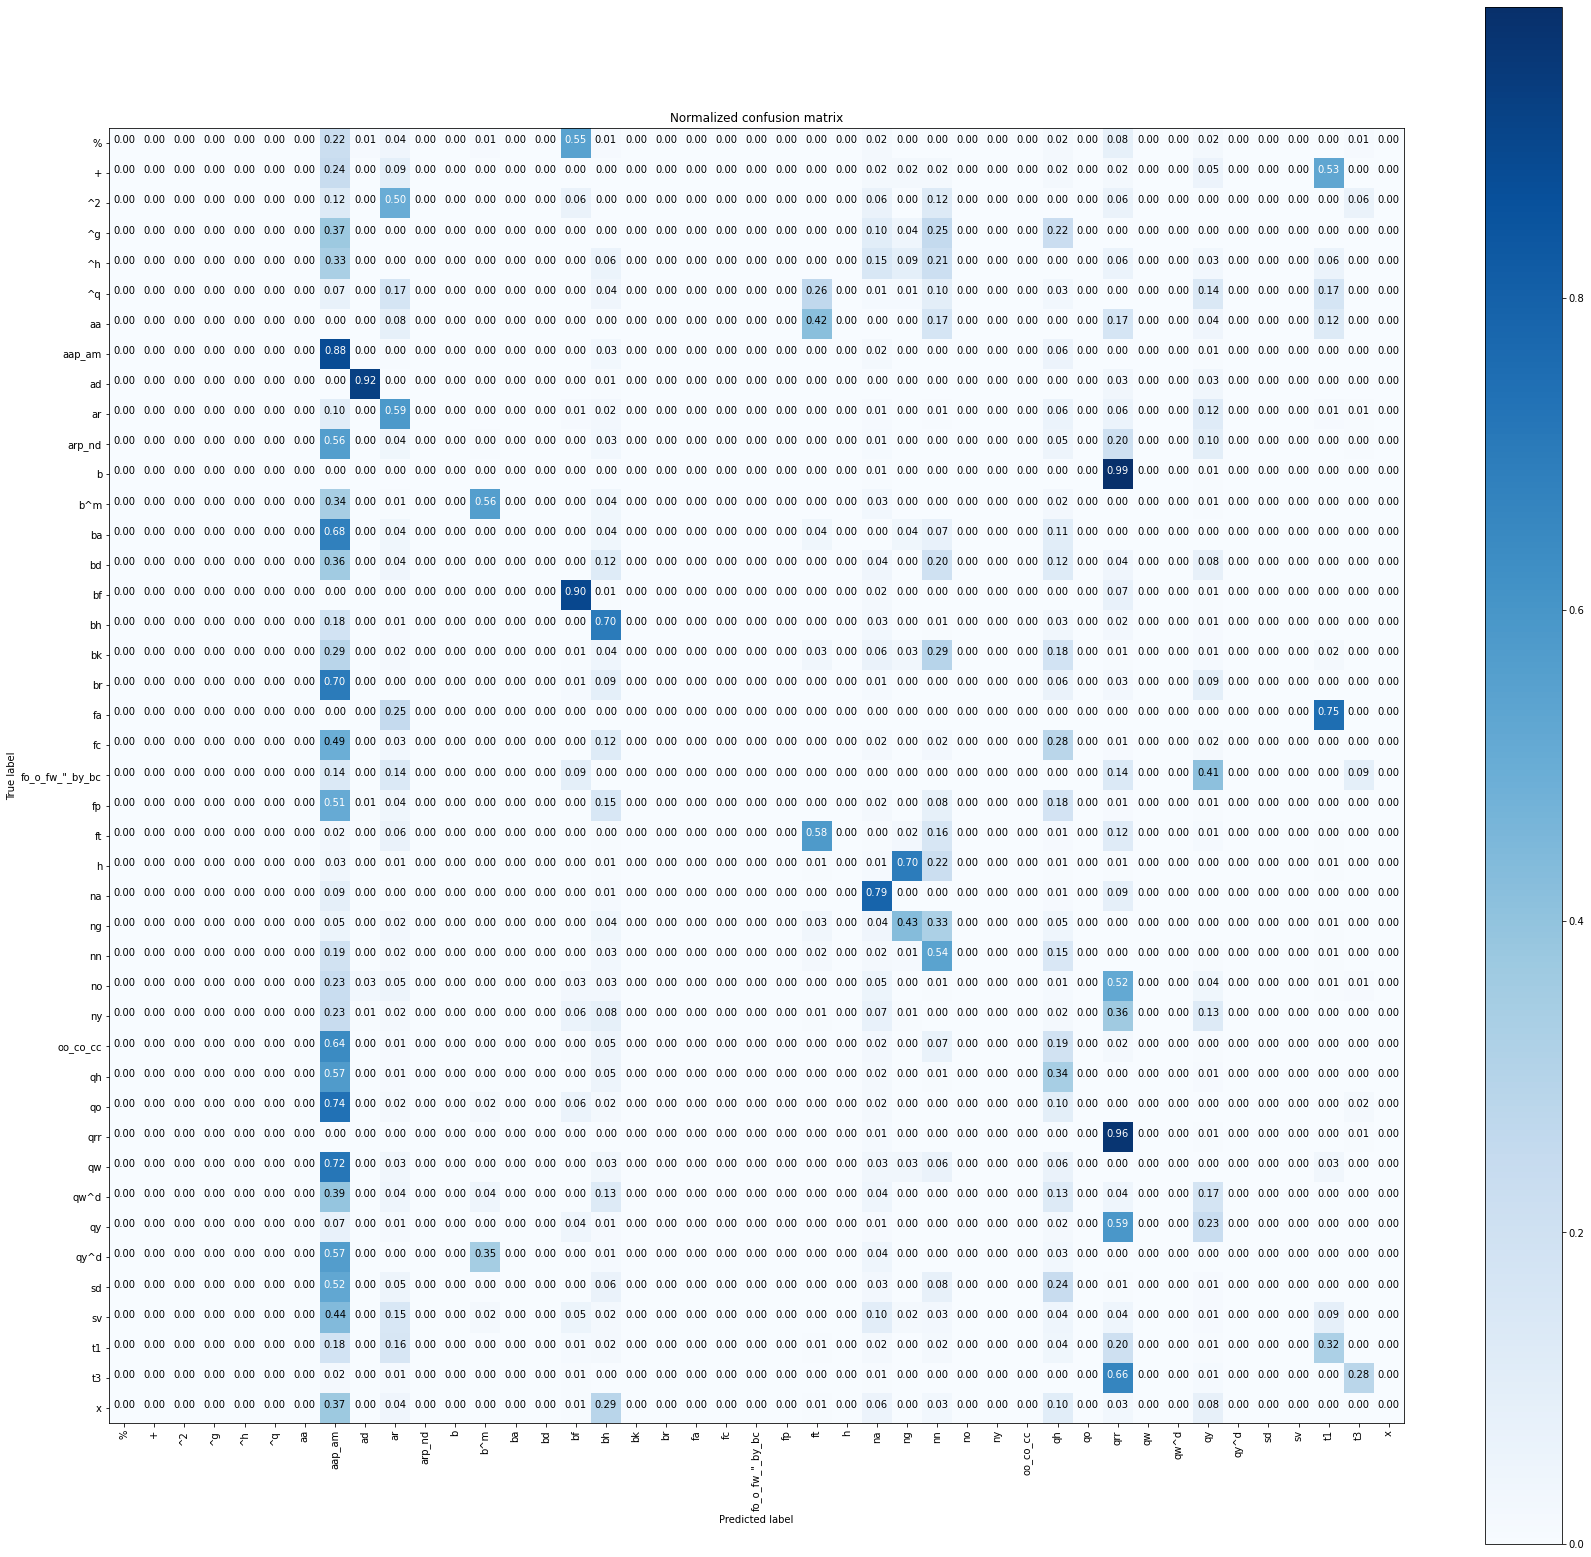

In [84]:
# Build the confusion matrix off these predictions
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import itertools
matrix = confusion_matrix(y_test.argmax(axis=1), pred_test.argmax(axis=1))
# classification_report(y_test.argmax(axis=1), pred_test.argmax(axis=1), target_names=one_hot_encoding_dic.columns)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

# y_pred = model.predict(x_test);
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(pred_test, axis=1))

# Plot normalized confusion matrix
fig = plt.figure()
fig.set_size_inches(24, 22, forward=True)
#fig.align_labels()

# fig.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0)
plot_confusion_matrix(cnf_matrix, classes=np.asarray(one_hot_encoding_dic.columns), normalize=True,
                      title='Normalized confusion matrix')

# fig.savefig("txt_classification-smote" + str(num_epochs) + ".png", pad_inches=5.0)



In [85]:
# Calculate Accuracies for "br" and "bf"
#Now the normalize the diagonal entries
# cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
#array([[1.        , 0.        , 0.        ],
#      [1.        , 0.        , 0.        ],
#      [0.        , 0.33333333, 0.66666667]])

#The diagonal entries are the accuracies of each class
cnf_matrix = matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
for i,j in zip(one_hot_encoding_dic.columns,cnf_matrix.diagonal()):
    if i=='br' or i=='bf':
        print(i,j)
#array([1.        , 0.        , 0.66


bf 0.8951406649616368
br 0.0



Due to the reduced lack of training data for the minority classes, these minority classifiers will not be very confident in classification, as they have not been fully optimised. The frequent classifiers will be more optimised and will generate more confident scores for all examples, effectively crowding out the less confident minority classifiers. 




# Model 2 - Balanced Network


One thing we can do to try to improve performance is therefore to balance the data more sensibly. As the dataset is highly imbalanced, we can simply weight up the minority classes proportionally to their underrepresentation while training. 

In [90]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

y_integers = np.argmax(tags_encoding, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

In [99]:
d_class_weights

{0: 15.072868217054264,
 1: 23.11173126614987,
 2: 65.82455107447748,
 3: 24.762569213732004,
 4: 50.48679160081282,
 5: 17.391771019677996,
 6: 55.91547886971743,
 7: 0.06896462388610163,
 8: 1.4138497919749105,
 9: 1.0840399280558102,
 10: 6.1106222501571335,
 11: 1.7105722154222767,
 12: 4.23809253046758,
 13: 65.00174418604651,
 14: 44.44563705028821,
 15: 3.7736861646471125,
 16: 0.27821622892749026,
 17: 8.996781202220971,
 18: 17.16217668278456,
 19: 66.66845557543232,
 20: 5.411175374488783,
 21: 50.00134168157424,
 22: 6.915079168728353,
 23: 4.91971573782755,
 24: 7.914976461010229,
 25: 0.33159925614613706,
 26: 2.613135444665186,
 27: 1.0924662888411178,
 28: 4.2554333346020625,
 29: 7.547372329294225,
 30: 5.273975187508845,
 31: 0.19603194989571837,
 32: 25.121447028423773,
 33: 0.13548733839357288,
 34: 47.273995771670194,
 35: 49.52513842746401,
 36: 0.4660876162842808,
 37: 18.182306066026996,
 38: 4.272916626855975,
 39: 9.33597762097616,
 40: 2.011659394539157,
 41: 

In [91]:
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

## Define & Train the model

In [109]:
# Re-built the model for the balanced training
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding
from keras.optimizers import Adam

#Building the network

# Include 2 BLSTM layers, in order to capture both the forward and backward hidden states

# Embedding layer
# Bidirectional 1
# Bidirectional 2
# Dense layer
# Activation
##
model_balanced = Sequential()
model_balanced.add(Embedding(VOCAB_SIZE,EMBED_SIZE,input_length=MAX_LENGTH))
# model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE,return_sequences=True,recurrent_dropout=0.7)))
model_balanced.add(Bidirectional(LSTM(HIDDEN_SIZE,recurrent_dropout=0.7)))
model_balanced.add(Dense(HIDDEN_SIZE))
# model.add(TimeDistributed(Dense(1)))
model_balanced.add(Activation('sigmoid'))
##
model_balanced.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'], )

model_balanced.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 137, 100)          4373100   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 86)                49536     
_________________________________________________________________
dense_8 (Dense)              (None, 43)                3741      
_________________________________________________________________
activation_8 (Activation)    (None, 43)                0         
Total params: 4,426,377
Trainable params: 4,426,377
Non-trainable params: 0
_________________________________________________________________


In [110]:
# Train the balanced network -  takes  time to achieve good accuracy
# Train the model - using validation 
history = model_balanced.fit(train_input,
                    train_labels,
                    epochs=20,
                    batch_size=256,
                    validation_data=(val_input, val_labels),
                    class_weight=d_class_weights,
                    verbose=1)

Train on 140000 samples, validate on 27704 samples
Epoch 1/20
140000/140000 [==============================] - 105s 751us/step - loss: 3.4882 - accuracy: 0.2358 - val_loss: 2.8830 - val_accuracy: 0.3668
Epoch 2/20
140000/140000 [==============================] - 103s 739us/step - loss: 2.4307 - accuracy: 0.3901 - val_loss: 2.0595 - val_accuracy: 0.4241
Epoch 3/20
140000/140000 [==============================] - 104s 741us/step - loss: 1.8213 - accuracy: 0.4368 - val_loss: 1.8901 - val_accuracy: 0.4464
Epoch 4/20
140000/140000 [==============================] - 103s 737us/step - loss: 1.4742 - accuracy: 0.4595 - val_loss: 1.7797 - val_accuracy: 0.4735
Epoch 5/20
140000/140000 [==============================] - 104s 742us/step - loss: 1.2285 - accuracy: 0.4976 - val_loss: 1.7691 - val_accuracy: 0.4497
Epoch 6/20
140000/140000 [==============================] - 103s 733us/step - loss: 1.0408 - accuracy: 0.5274 - val_loss: 1.6945 - val_accuracy: 0.4856
Epoch 7/20
140000/140000 [===========

## Test the model

In [111]:
# Overall Accuracy
score = model_balanced.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 34s 606us/step


In [112]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 53.29862833023071


In [115]:
# Generate predictions for the test data
label_pred = model_balanced.predict(test_sentences_X, batch_size=100)

## Balanced network evaluation

Report the overall accuracy and the accuracy of  'br' and 'bf'  classes. Suggest other ways to handle imbalanced classes.

In [116]:
# Build the confusion matrix off these predictions

matrix_balanced = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))

# Calculate Accuracies for "br" and "bf"
cnf_matrix = matrix_balanced.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
for i,j in zip(one_hot_encoding_dic.columns,cnf_matrix.diagonal()):
    if i=='br' or i=='bf':
        print(i,j)


bf 0.80306905370844
br 0.3116883116883117




### Accuracies



### Explanation


### Other ways to handle imbalanced classes


- 

- 

Can we improve things by using context information?  Next we try to build a model which predicts DA tag from the sequence of 
previous DA tags, plus the utterance representation. 

# Using Context for Dialog Act Classification

The second approach we will try is a hierarchical approach to DA tagging. We expect there is valuable sequential information among the DA tags. So in this section we apply a BiLSTM on top of the sentence CNN representation. The CNN model learns textual information in each utterance for DA classification, acting like the text classifier from Model 1 above. Then we use a bidirectional-LSTM (BLSTM) above that to learn how to use the context before and after the current utterance to improve the output.

## Define the model

This model has an architecture of:

- Word Embedding
- CNN
- Bidirectional LSTM
- Fully-Connected output



## CNN


This is a classical CNN layer used to convolve over embedings tensor and gether useful information from it. The data is represented by hierarchy of features, which can be modelled using a CNN. We transform/reshape conv output to 2d matrix. Then we pass it to the max pooling layer that applies the max pool operation on windows of different sizes.

In [21]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras import Model,Input
# from keras.layers.merge import Concatenate
from keras.layers import Dropout, InputLayer, Bidirectional, TimeDistributed, Activation, Embedding, Reshape, concatenate, Conv2D, BatchNormalization, MaxPool2D, Flatten
from keras.optimizers import Adam

filter_sizes = [3,4,5]
num_filters = 64
drop = 0.2
VOCAB_SIZE = len(wordvectors) # 43,731
MAX_LENGTH = len(max(sentences, key=len))
EMBED_SIZE = 100 # arbitary
HIDDEN_SIZE = len(unique_tags) 

# CNN model
inputs = Input(shape=(MAX_LENGTH, ), dtype='int32')
embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBED_SIZE, input_length=MAX_LENGTH)(inputs)
reshape = Reshape((MAX_LENGTH, EMBED_SIZE, 1))(embedding)

# 3 convolutions
conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_0 = BatchNormalization()(conv_0)
conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_1 = BatchNormalization()(conv_1)
conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], EMBED_SIZE), strides=1, padding='valid', kernel_initializer='normal', activation='relu')(reshape)
bn_2 = BatchNormalization()(conv_2)

# maxpool for 3 layers
maxpool_0 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[0] + 1, 1), padding='valid')(bn_0)
maxpool_1 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[1] + 1, 1), padding='valid')(bn_1)
maxpool_2 = MaxPool2D(pool_size=(MAX_LENGTH - filter_sizes[2] + 1, 1), padding='valid')(bn_2)

# concatenate tensors
# concatenate_tensors = Concatenate()([maxpool_0, maxpool_1, maxpool_2]) # dim 4
concatenate_tensors = concatenate([maxpool_0, maxpool_1,maxpool_2],axis=-1)
# flatten concatenated tensors
flatten_concat = Flatten()(concatenate_tensors) # dim 2
# dense layer (dense_1)
dense_1 = Dense(HIDDEN_SIZE)(flatten_concat) # dim 2
# dropout_1
dropout_1 = Dropout(drop)(dense_1) # dim 2

Instructions for updating:
Colocations handled automatically by placer.


## BLSTM

This is used to create LSTM layers. The data we’re working with has temporal properties which we want to model as well — hence the use of a LSTM. You should create a BiLSTM.

In [22]:
# BLSTM model
time_xx = TimeDistributed(Dense(HIDDEN_SIZE))(concatenate_tensors)
time_xx_reshape = Reshape((time_xx.shape[1]*time_xx.shape[2],int(time_xx.shape[3])),input_shape=time_xx.shape[1:4])(time_xx)
# https://github.com/keras-team/keras/issues/11425

# Bidirectional 1
b1 = Bidirectional(LSTM(HIDDEN_SIZE, return_sequences=True))(time_xx_reshape)
# Bidirectional 2
b2 = Bidirectional(LSTM(HIDDEN_SIZE))(b1)
# Dense layer (dense_2)
dense_2 = Dense(HIDDEN_SIZE)(b2)
# dropout_2
dropout_2 = Dropout(drop)(dense_2)


Concatenate 2 last layers and create the output layer

In [23]:
# concatenate 2 final layers
y = concatenate([dropout_1, dropout_2],axis = -1)
# output
# out = Activation('sigmoid')(y)
out = Dense(HIDDEN_SIZE)(y)
out = Activation('sigmoid')(out)
m = Model(inputs,out)
m.compile(loss='categorical_crossentropy',optimizer='sgd',metrics=['accuracy'], )
m.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 137)          0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 137, 100)     4373100     input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 137, 100, 1)  0           embedding_1[0][0]                
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 135, 1, 64)   19264       reshape_1[0][0]                  
____________________________________________________________________________________________

In [35]:
!pip install pydot

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


In [36]:
import pydot
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(m, show_shapes=True,show_layer_names=True).create(prog='dot', format='svg'))

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [24]:
# Train the model - using validation 
history = m.fit(train_input,
                    train_labels,
                    epochs=30,
                    batch_size=128,
                    validation_data=(val_input, val_labels),
                    verbose=1)


Instructions for updating:
Use tf.cast instead.
Train on 140000 samples, validate on 27704 samples
Epoch 1/30
140000/140000 [==============================] - 16s 115us/step - loss: 1.8030 - accuracy: 0.5263 - val_loss: 1.3179 - val_accuracy: 0.6083
Epoch 2/30
140000/140000 [==============================] - 13s 89us/step - loss: 1.3007 - accuracy: 0.6280 - val_loss: 1.1731 - val_accuracy: 0.6477
Epoch 3/30
140000/140000 [==============================] - 13s 92us/step - loss: 1.1790 - accuracy: 0.6568 - val_loss: 1.1718 - val_accuracy: 0.6200
Epoch 4/30
140000/140000 [==============================] - 13s 91us/step - loss: 1.1060 - accuracy: 0.6720 - val_loss: 1.0704 - val_accuracy: 0.6680
Epoch 5/30
140000/140000 [==============================] - 13s 90us/step - loss: 1.0563 - accuracy: 0.6833 - val_loss: 1.0211 - val_accuracy: 0.6868
Epoch 6/30
140000/140000 [==============================] - 13s 92us/step - loss: 1.0181 - accuracy: 0.6925 - val_loss: 1.0082 - val_accuracy: 0.6877


In [25]:
score = m.evaluate(test_sentences_X, y_test, batch_size=100)

55902/55902 [==============================] - 2s 38us/step


In [26]:
print("Overall Accuracy:", score[1]*100)

Overall Accuracy: 69.4966197013855


In [27]:
# Generate predictions for the test data
label_pred = m.predict(test_sentences_X, batch_size=100)

In [28]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_confusion_matrix
import itertools

In [29]:
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(label_pred, axis=1))

In [30]:
# Build the confusion matrix off these predictions

matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), label_pred.argmax(axis=1))

# Calculate Accuracies for "br" and "bf"
cnf_matrix_ = matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]
for i,j in zip(one_hot_encoding_dic.columns,cnf_matrix_.diagonal()):
    if i=='br' or i=='bf':
        print(i,j)


bf 0.3968253968253968
br 0.0755813953488372


Report your overall accuracy. Did context help disambiguate and better predict the minority classes ('br' and 'bf')? What are frequent errors? Show one positive example where adding context changed the prediction.




### Minority Classes



# Advanced:  Bert-Based Model for Dialogue Act Tagging

In the last section we want to use BERT and leverage contextual word embeddings, following on from the last lab you've 
just done. This is an advanced part of the assignment and worth 10 marks (20%) in total. You could use your BERT-based text classifier here (instead of the CNN utterance-level classifier) and see if a pre-trained BERT language model helps. The domain difference from conversational data is one possible downside to using BERT. Explore some techniques to efficiently transfer the knowledge from conversational data and to improve model performance on DA tagging.